In [40]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import os
import glob
import datetime
import time
from functions import preproc_nemo
from functions import yearFraction
expname='res1'
expdir=os.path.join('/lus/h2resw01/scratch/itas/ece4/', expname, 'output', 'nemo')

In [2]:
domain = xr.open_dataset(os.path.join(expdir, '..', '..', 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
area = domain['e1t']*domain['e2t']

In [3]:
filelist = glob.glob(os.path.join(expdir, 'res1_oce_1m_T_*.nc'))
data = xr.open_mfdataset(filelist[1:], preprocess=preproc_nemo)
#data = preproc_nemo(data)
#data = data.rename_dims({'deptht': 'z'})
#data = data.rename({'deptht': 'z'})
#gridT = preproc_nemo(gridT)
data

/lus/h2resw01/hpcperm/itas/src/github/stece/martini/functions.py:4: UserWarning: rename 'deptht' to 'z' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  field = field.rename({'deptht': 'z','time_counter': 'time'})
/lus/h2resw01/hpcperm/itas/src/github/stece/martini/functions.py:4: UserWarning: rename 'time_counter' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  field = field.rename({'deptht': 'z','time_counter': 'time'})


<xarray.Dataset>
Dimensions:               (y: 331, x: 360, z: 75, time: 60, axis_nbounds: 2,
                           y_grid_T_inner: 331, x_grid_T_inner: 360)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
  * z                     (z) float32 0.5 1.55 2.661 ... 5.698e+03 5.902e+03
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1990-01-16T12:00:00 ... 1994-...
Dimensions without coordinates: y, x, axis_nbounds, y_grid_T_inner,
                                x_grid_T_inner
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    thetao                (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    name:         output/nemo/res1_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Oct-05 15:45:43 GMT
    uuid:         379edbf8-c29b-4a2a-8027-553581697456

In [4]:
mask = xr.where(data.thetao.isel(time=0)>0, 1, float('NaN'))

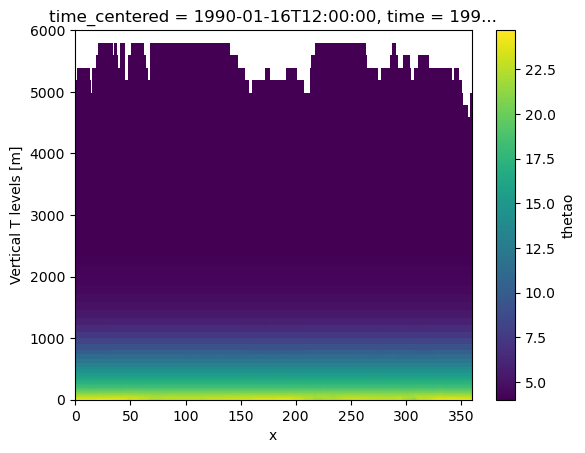

In [5]:
data.thetao.isel(time=0).mean(dim=['y']).plot()

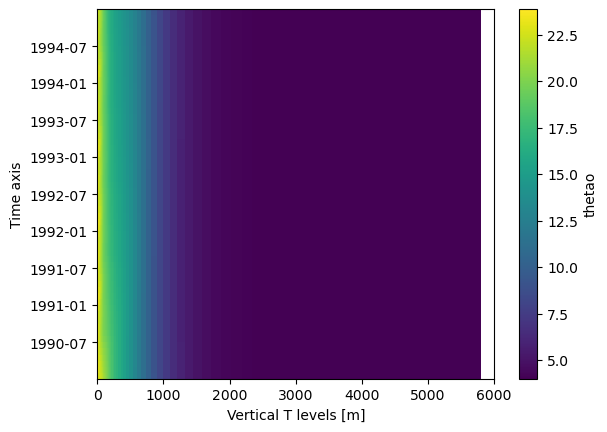

In [6]:
out = data.thetao.mean(dim=['y', 'x']).plot()

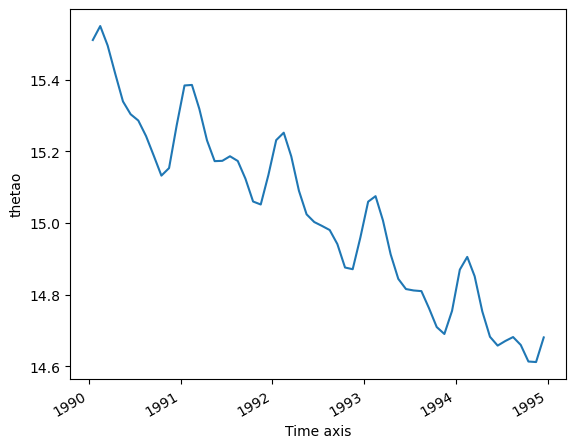

In [7]:
out3d = data.thetao.mean(dim=['z','y', 'x']).plot()

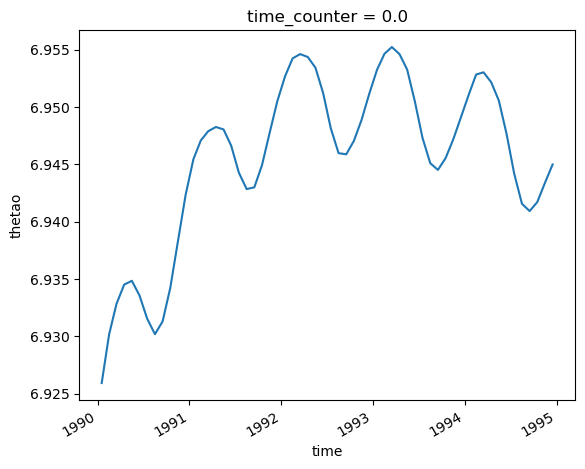

In [8]:
outw = data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).plot()

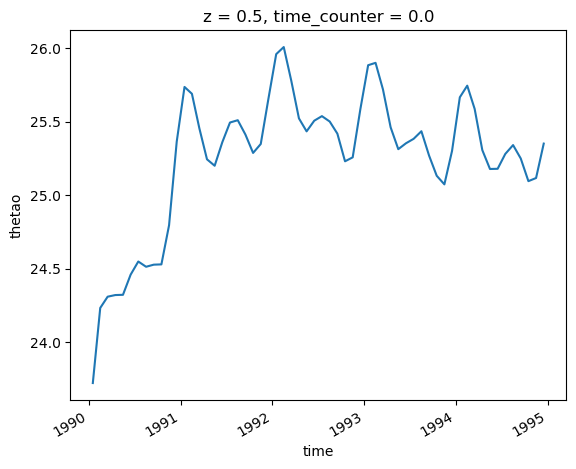

In [9]:
outs = data.thetao.isel(z=0).weighted(area).mean(dim=['y', 'x']).plot()

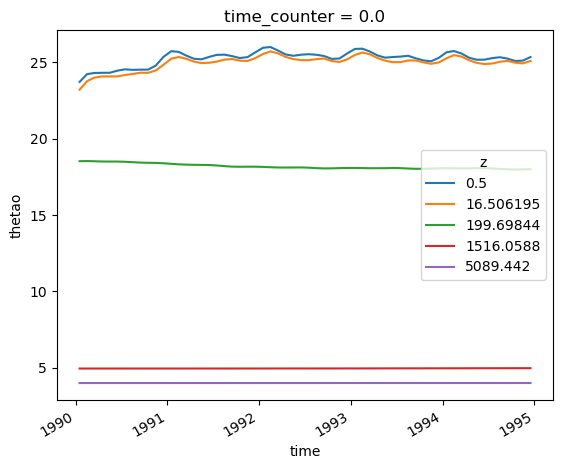

In [10]:
thetaz = data.thetao.isel(z=[0,10,30,50,70]).weighted(area).mean(dim=['y', 'x']).plot(x='time',hue='z')

In [11]:
tev=data['thetao'].values
zv=data['z'].values
tv=data['time'].values

In [12]:
model=LinearRegression()

In [13]:
zf=0
te1 = data.thetao.isel(z=zf).weighted(area).mean(dim=['y', 'x']).values
time1 = data['time'].values
print(len(te1),len(time1))

60 60


In [44]:
future = datetime.datetime.now()
futureF = yearFraction(future)
print(futureF)

NameError: name 'datetime' is not defined